# AI-Powered Real-Time News Effects on Stock Market Changes

In [1]:
import requests
import time
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta, timezone
from IPython.display import display

import yfinance as yf
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from transformers import BertTokenizer, BertModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK models are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import warnings
warnings.filterwarnings("ignore")  # Hide all warnings

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### ======================================================================================================
#### ======================================================================================================


## Stock and News Activity in the Three Hours After Market Close

In [111]:
import requests
import pandas as pd

api_key = "demo"

# Fetch IBM stock data
stock_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey={api_key}'
df_stock = pd.DataFrame.from_dict(
    requests.get(stock_url).json()['Time Series (1min)'], orient='index'
)

df_stock.index = pd.to_datetime(df_stock.index)
df_stock.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df_stock['Ticker'] = 'IBM'

latest_time = df_stock.index.max()

# Print timestamp header
print("\n==================== LAST STOCK TIMESTAMP ====================")
print(f"The stock market closed at: {latest_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("=================================================================\n")

# Filter last 3 hours
df_stock_filtered = df_stock[df_stock.index >= latest_time - pd.Timedelta(hours=3)].reset_index()
df_stock_filtered.rename(columns={'index': 'Stock_Timestamp'}, inplace=True)

# Fetch Apple news sentiment data
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey={api_key}'
df_news = pd.DataFrame(requests.get(news_url).json()['feed'])

df_news['time_published'] = pd.to_datetime(df_news['time_published'])
df_news_filtered = df_news[df_news['time_published'] >= latest_time - pd.Timedelta(hours=3)]

# Select key columns
df_news_filtered = df_news_filtered[['title', 'summary', 'source', 'url']]

# Merge stock with news data
df_merged = df_stock_filtered.join(df_news_filtered, how='left')

# Reorder columns
df_merged = df_merged[['Stock_Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'title', 'summary', 'source', 'url']]

df_merged.to_csv('merged_stock_news_last_3_hours.csv', index=False)

df_merged.head()



==================== LAST STOCK TIMESTAMP ====================
The stock market closed at: 2025-02-28 19:59:00



,Stock_Timestamp,Open,High,Low,Close,Volume,title,summary,source,url
0,2025-02-28 19:59:00,252.5000,252.5000,252.5000,252.5000,1,Consumer Tech News ( Feb 24-Feb 28 ) : Austra...,"Grok, the AI chatbot developed by xAI briefly ...",Benzinga,https://www.benzinga.com/news/large-cap/25/03/...
1,2025-02-28 19:58:00,252.5000,252.5000,252.0300,252.0300,45,"Should You Buy Bitcoin While It's Under $90,000?",Bitcoin ( CRYPTO: BTC ) investors were taken o...,Motley Fool,https://www.fool.com/investing/2025/03/01/shou...
2,2025-02-28 19:53:00,252.5000,252.5000,252.5000,252.5000,116,This Bill Gates 'Mistake' Cost Microsoft A $40...,Microsoft Corp. MSFT co-founder Bill Gates adm...,Benzinga,https://www.benzinga.com/25/03/44065138/this-b...
3,2025-02-28 19:51:00,252.5000,252.5000,252.5000,252.5000,15,3 Can't-Miss Takeaways From Warren Buffett's L...,Berkshire Hathaway ( NYSE: BRK.A ) ( NYSE: BRK...,Motley Fool,https://www.fool.com/investing/2025/03/01/3-ca...
4,2025-02-28 19:49:00,252.5000,252.5000,252.5000,252.5000,4,Wall Street Is Shying Away From The 'Mag-7' As...,Tech giants that have dominated Wall Street fo...,Benzinga,https://www.benzinga.com/news/25/02/44062519/w...


#### ======================================================================================================
#### ======================================================================================================


#### AI-Powered Real-Time News Effects on Stock Market Changes:  Data Analysis and Model Building

### 1. News Articles Retrieval

In [ ]:

# API Key (Ensure it is valid)
API_KEY = "ZA30G8RYRWTYDRCQ"

# Expanded tickers list for more articles
TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX', 'IBM', 'AMD', 
    'BA', 'JPM', 'V', 'PG', 'DIS', 'INTC', 'ORCL', 'CSCO', 'PEP', 'KO', 'XOM', 'WMT',
    'T', 'PFE', 'COST', 'NKE', 'HON', 'GE', 'ADBE', 'CRM', 'PYPL', 'UBER', 'LYFT'
]

BASE_URL = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT"
TARGET_ARTICLES = 2000  # Minimum required articles
all_articles = []
global_count = 0

# Function to fetch news data
def fetch_news(url, ticker="GENERAL"):
    global global_count
    response = requests.get(url)
    if response.status_code != 200:
        print(f"⚠ Warning: Failed to fetch data for {ticker}")
        return
    
    data = response.json()
    articles = data.get("feed", [])
    
    for article in articles:
        if global_count >= TARGET_ARTICLES:
            return  
        
        try:
            article_time = datetime.strptime(article["time_published"], "%Y%m%dT%H%M%S").replace(tzinfo=timezone.utc)
        except ValueError:
            continue  # Skip articles with incorrect date format

        all_articles.append({
            "Ticker": ticker,
            "Title": article.get("title", "N/A"),
            "URL": article.get("url", "N/A"),
            "Time Published": article.get("time_published", "N/A"),
            "Article Time": article_time,
            "Sentiment": article.get("overall_sentiment_label", "N/A"),
        })
        global_count += 1

# Fetch news for each ticker
for ticker in TICKERS:
    if global_count >= TARGET_ARTICLES:
        break  
    url = f"{BASE_URL}&tickers={ticker}&apikey={API_KEY}"
    fetch_news(url, ticker)
    time.sleep(12)  # Avoid hitting rate limits

# Fetch broad market news (if needed)
if global_count < TARGET_ARTICLES:
    topics = ["business", "finance", "technology", "world"]
    for topic in topics:
        if global_count >= TARGET_ARTICLES:
            break  
        url = f"{BASE_URL}&topics={topic}&apikey={API_KEY}"
        fetch_news(url, "GENERAL")
        time.sleep(12)  # Avoid hitting rate limits

# Ensure at least 2000 articles
if global_count < TARGET_ARTICLES:
    print(f"⚠ Warning: Only {global_count} articles found, below the minimum of {TARGET_ARTICLES}.")

# Sort articles by "Article Time" (most recent first)
all_articles.sort(key=lambda x: x["Article Time"], reverse=True)

# Convert to DataFrame
df = pd.DataFrame(all_articles)

# Save to CSV
csv_filename = "News_data_updated5.csv"
df.to_csv(csv_filename, index=False)

print(f"✅ News data saved to {csv_filename} with {global_count} articles.")



In [6]:
# Display first few articles
df.head(50)


""


#### Stock Data Retrieval 

In [ ]:

# List of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX', 'IBM', 'AM']

# Function to fetch intraday stock data starting from today
def get_intraday_stock_data_today(tickers, interval="1m"):
    stock_data = []

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="6d", interval=interval)  # Fetch data for today

        if not hist.empty:
            # Extract relevant data for today
            for timestamp, row in hist.iterrows():
                stock_data.append({
                    "Ticker": ticker,
                    "Timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
                    "Open": row["Open"],
                    "High": row["High"],
                    "Low": row["Low"],
                    "Close": row["Close"],
                    "Volume": row["Volume"]
                })

    return pd.DataFrame(stock_data)

# Get today's intraday stock data
df = get_intraday_stock_data_today(tickers, interval="1m")  # "1m" for 1-minute intervals

# Convert 'Timestamp' column to datetime for sorting
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the DataFrame based on 'Timestamp'
df = df.sort_values(by='Timestamp', ascending=False)  # Sort latest to past

# Save to CSV file
csv_filename = "stock_data671.csv"
df.to_csv(csv_filename, index=False)

In [8]:

print(f"Stock data for today sorted by time saved to {csv_filename}")
df.head()  # Show the first few rows of the data



             Timestamp      Open      High       Low     Close Volume
99 2025-02-20 15:40:00  264.7700  264.8400  264.7410  264.7900  10350
98 2025-02-20 15:41:00  264.7800  264.8300  264.7350  264.8300  13022
97 2025-02-20 15:42:00  264.7602  264.8200  264.7602  264.8000   6877
96 2025-02-20 15:43:00  264.7650  264.7900  264.5200  264.7300  22522
95 2025-02-20 15:44:00  264.7300  264.7500  264.6900  264.6900   8141


#### Data Preprocessing 

#### Merging the two datasets based on the Timestamp

In [110]:
# Load the CSV files
new_data = pd.read_csv("News_data_updated.csv")
stock_data = pd.read_csv("stock_data.csv")

# Display column names for both datasets
print("Columns in New_data.csv:")
print(new_data.columns.tolist())

print("\nColumns in stock_data.csv:")
print(stock_data.columns.tolist())


Columns in New_data.csv:
['Ticker', 'Title', 'URL', 'Time Published', 'Article Time', 'Sentiment']

Columns in stock_data.csv:
['Ticker', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']


In [42]:
# Load the datasets
new_data = pd.read_csv("News_data_updated.csv")
stock_data = pd.read_csv("stock_data.csv")

# Convert time columns to datetime format and remove timezone
new_data["Article Time"] = pd.to_datetime(new_data["Article Time"]).dt.tz_localize(None).dt.floor("min")
stock_data["Timestamp"] = pd.to_datetime(stock_data["Timestamp"]).dt.floor("min")

# Merge data using article time, with a ±5-minute range
merged_data = pd.merge_asof(
    new_data.sort_values("Article Time"),
    stock_data.sort_values("Timestamp"),
    left_on="Article Time",
    right_on="Timestamp",
    by="Ticker",
    tolerance=pd.Timedelta("10min"),  # Allow ±5 minutes range
    direction="nearest"  # Pick the closest match
)

# Remove unmatched rows (keep only successfully merged data)
merged_data = merged_data.dropna()

# Drop 'Article Time', 'Time Published', and 'Sentiment' columns
merged_data = merged_data.drop(columns=["Article Time", "Time Published", "Sentiment"])

# Sort by Timestamp in descending order to start with the latest data
merged_data = merged_data.sort_values(by="Timestamp", ascending=False)

# Save matched data to a new CSV file
merged_data.to_csv("Matched_Data.csv", index=False)

# Display the first few rows
merged_data.head()


,Ticker,Title,URL,Timestamp,Open,High,Low,Close,Volume
1187,MSFT,Is the Fidelity Yield Enhanced Equity ETF's Pr...,https://www.fool.com/investing/2025/02/21/is-f...,2025-02-21 10:27:00,413.290009,413.290009,413.290009,413.290009,0.0
1186,META,Is the Fidelity Yield Enhanced Equity ETF's Pr...,https://www.fool.com/investing/2025/02/21/is-f...,2025-02-21 10:27:00,697.020020,697.020020,697.020020,697.020020,0.0
1185,NVDA,Is the Fidelity Yield Enhanced Equity ETF's Pr...,https://www.fool.com/investing/2025/02/21/is-f...,2025-02-21 10:27:00,139.229996,139.229996,139.229996,139.229996,0.0
1184,AAPL,Apple's Visual Intelligence May Come To iPhone...,https://www.benzinga.com/tech/25/02/43876492/a...,2025-02-21 10:23:00,245.850006,246.009995,245.740005,245.845001,68829.0
1183,META,3 Artificial Intelligence Stocks You Can Buy a...,https://www.fool.com/investing/2025/02/21/arti...,2025-02-21 10:15:00,700.250000,700.580017,699.443298,700.250000,37514.0


#### Data Overview 

In [43]:
# Load Data
# Assume merged_data is already loaded in memory
print("Dataset Info:")
print(merged_data.info())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 1187 to 682
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     151 non-null    object        
 1   Title      151 non-null    object        
 2   URL        151 non-null    object        
 3   Timestamp  151 non-null    datetime64[ns]
 4   Open       151 non-null    float64       
 5   High       151 non-null    float64       
 6   Low        151 non-null    float64       
 7   Close      151 non-null    float64       
 8   Volume     151 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 11.8+ KB
None


In [44]:

print("\nMissing Values:")
print(merged_data.isnull().sum())




Missing Values:
Ticker       0
Title        0
URL          0
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


In [45]:
print("\nSummary Statistics:")
merged_data.describe()


Summary Statistics:


,Timestamp,Open,High,Low,Close,Volume
count,151,151.000000,151.000000,151.000000,151.000000,1.510000e+02
mean,2025-02-20 08:16:36.556291328,384.153477,384.326962,383.975625,384.141857,2.659568e+05
min,2025-02-18 10:45:00,137.139999,137.249207,136.910004,137.050201,0.000000e+00
25%,2025-02-20 09:30:00,222.747246,222.905006,222.680000,222.752502,2.165050e+04
50%,2025-02-20 12:00:00,245.589996,245.839996,245.539993,245.600006,4.706100e+04
75%,2025-02-20 14:24:00,417.897995,418.025009,417.814011,417.907745,1.296690e+05
max,2025-02-21 10:27:00,1043.790039,1043.929932,1042.819946,1042.859985,1.064193e+07
std,NaN,262.740915,262.826458,262.669633,262.753462,1.093367e+06


In [46]:
# Convert Timestamp to Datetime (if not already in datetime format)
merged_data["Timestamp"] = pd.to_datetime(merged_data["Timestamp"])

#### EDA

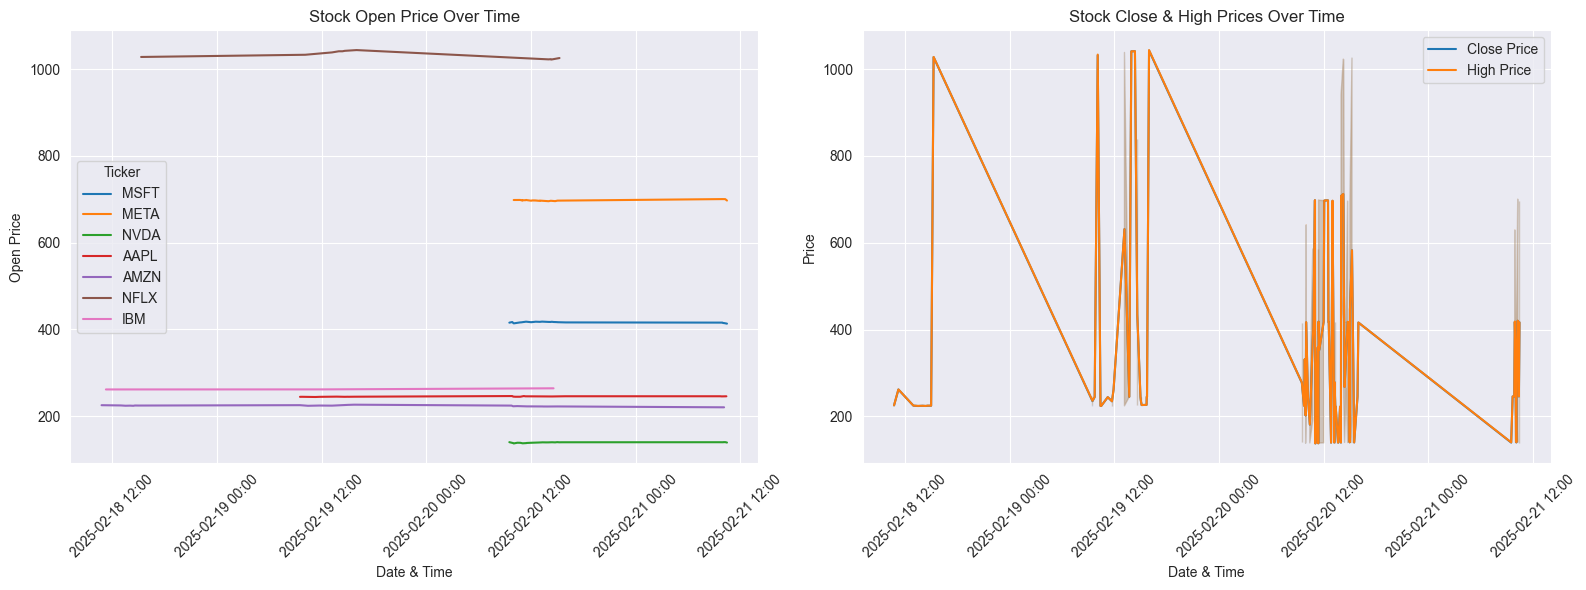

In [47]:

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
sns.set_style("darkgrid")

# Function to format x-axis (showing both date and time)
def format_xaxis(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='x', rotation=45)

# Subplot 1: Open Price Over Time
sns.lineplot(x=merged_data["Timestamp"], y=merged_data["Open"], hue=merged_data["Ticker"], ax=axes[0])
axes[0].set_title("Stock Open Price Over Time")
axes[0].set_xlabel("Date & Time")
axes[0].set_ylabel("Open Price")
format_xaxis(axes[0])
axes[0].legend(title="Ticker")

# Subplot 2: Close & High Price Over Time
sns.lineplot(x=merged_data["Timestamp"], y=merged_data["Close"], label="Close Price", ax=axes[1])
sns.lineplot(x=merged_data["Timestamp"], y=merged_data["High"], label="High Price", ax=axes[1])
axes[1].set_title("Stock Close & High Prices Over Time")
axes[1].set_xlabel("Date & Time")
axes[1].set_ylabel("Price")
format_xaxis(axes[1])
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


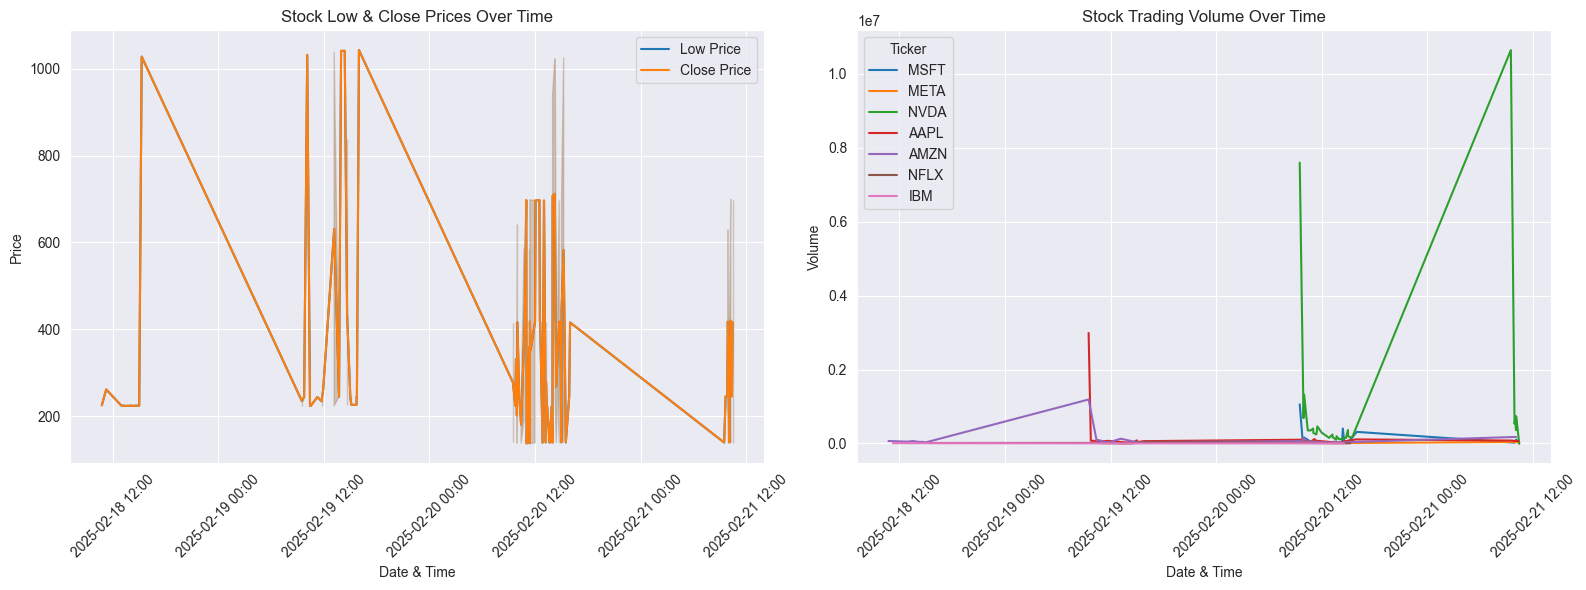

In [48]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns
sns.set_style("darkgrid")

# Function to format x-axis (showing both date and time)
def format_xaxis(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='x', rotation=45)

# Subplot 1: Low & Close Price Over Time
sns.lineplot(x=merged_data["Timestamp"], y=merged_data["Low"], label="Low Price", ax=axes[0])
sns.lineplot(x=merged_data["Timestamp"], y=merged_data["Close"], label="Close Price", ax=axes[0])
axes[0].set_title("Stock Low & Close Prices Over Time")
axes[0].set_xlabel("Date & Time")
axes[0].set_ylabel("Price")
format_xaxis(axes[0])
axes[0].legend()

# Subplot 2: Trading Volume Over Time
sns.lineplot(x=merged_data["Timestamp"], y=merged_data["Volume"], hue=merged_data["Ticker"], ax=axes[1])
axes[1].set_title("Stock Trading Volume Over Time")
axes[1].set_xlabel("Date & Time")
axes[1].set_ylabel("Volume")
format_xaxis(axes[1])
axes[1].legend(title="Ticker")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


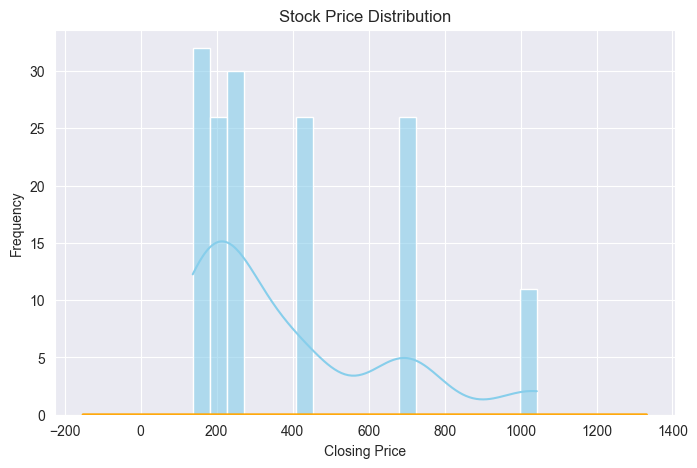

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Stock Prices
plt.figure(figsize=(8, 5))

# Plot histogram with custom color
sns.histplot(merged_data["Close"], bins=20, kde=True, color='skyblue', alpha=0.6)

# Customize the KDE line color
sns.kdeplot(merged_data["Close"], color='orange', linewidth=2)

plt.title("Stock Price Distribution")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

#### NLP Preprocessing (Text Cleaning)

In [50]:
# Clean Text Function for News Titles
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

# Apply text cleaning to Title column
merged_data['cleaned_title'] = merged_data['Title'].apply(clean_text)

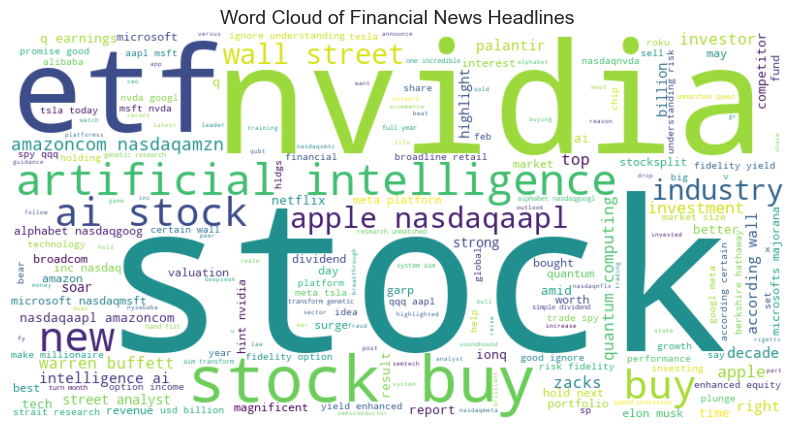

In [72]:
from wordcloud import WordCloud

# Combine all cleaned news titles
all_text = " ".join(merged_data["cleaned_title"])

# Generate Word Cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_text)

# Display the Word Cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Financial News Headlines", fontsize=14)
plt.show()


#### Normalize Stock Price Features